# Search Log Viewer
Parse and visualize the logs from the search base class

In [5]:
import os
import sys
from pathlib import Path
import json
import matplotlib.pyplot as plt

# Default plot size
plt.rcParams["figure.figsize"] = [20,10]

In [22]:
def plot_log(log_file):
    with open(log_file, "r", encoding="utf8") as f:
        log_data = json.load(f)
    current_iou = 0
    valid_step = []
    valid_iou = []
    invalid_step = []
    invalid_iou = []
    for action in log_data:
        step = action["step"]
        iou = action["iou"]
        if iou is None:
            invalid_step.append(step)
            invalid_iou.append(current_iou)
        else:
            valid_step.append(step)
            valid_iou.append(iou)
            current_iou = iou
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.set_ylim([0,1])
    ax.scatter(invalid_step, invalid_iou, color='r')
    ax.scatter(valid_step, valid_iou, color='b')
    ax.set_xlabel('Step')
    ax.set_ylabel('IoU')
    ax.set_title(f"{log_file.stem}")
    plt.show()

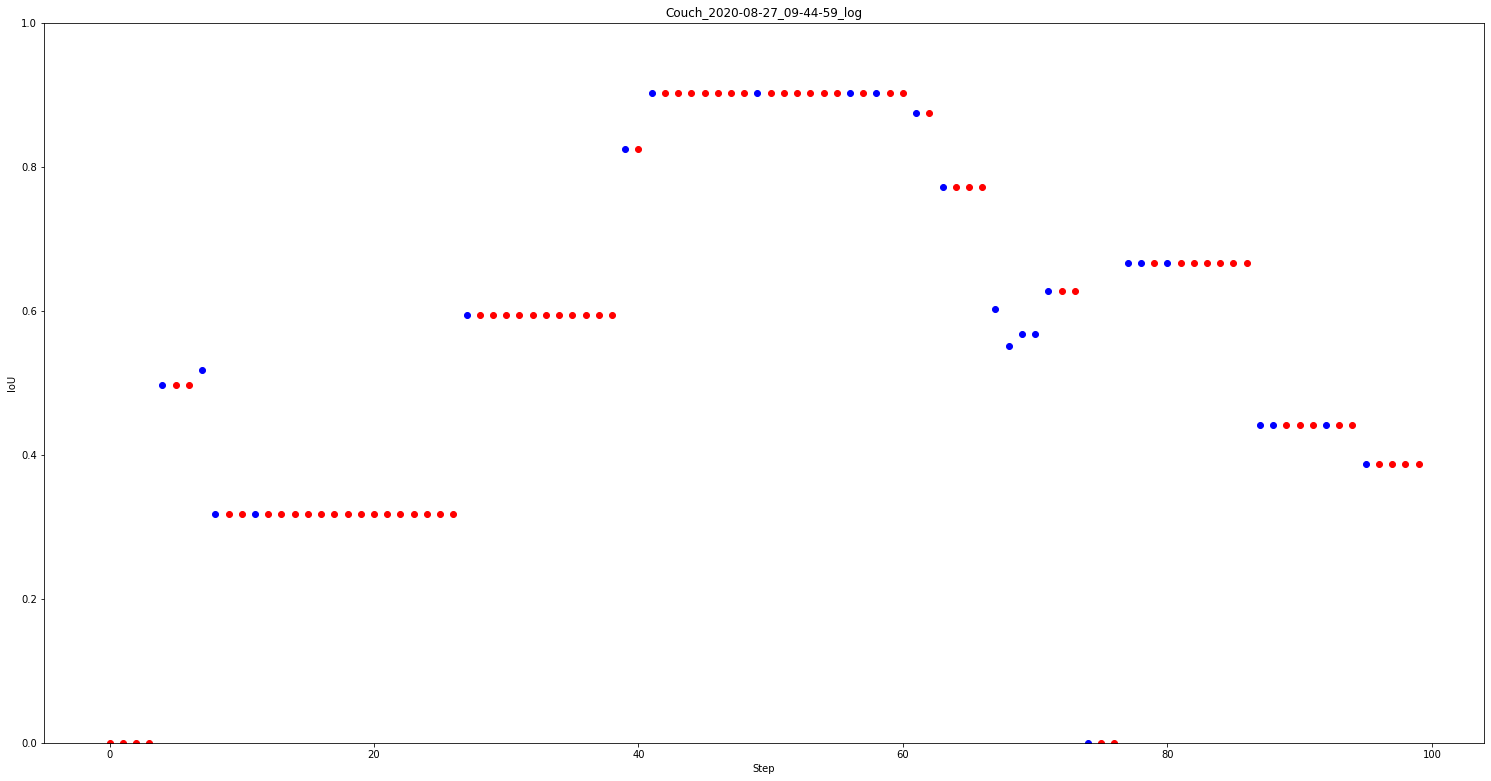

In [24]:
log_file = Path("Couch_2020-08-27_09-44-59_log.json")
plot_log(log_file)